In [1]:
import numpy as np
import pandas as pd
import random


def randomaccess(numnodes, beaconinterval, frametxslot, per, raalgo):
    if raalgo == 'CSMA':
        slottime = 9
        currentslot = 0
        # print(f"Data frame length: {frametxslot}")
        contentionwindowsize = [2**x for x in range(5, 11)]
        # Backoff counter initialize
        bo_stage = np.zeros(numnodes, dtype=int)
        bo_counter = np.array([np.random.randint(contentionwindowsize[x]) for x in bo_stage])

        num_succ = 0
        num_fail = 0
        num_coll = 0
        succ_timestamp = np.array([], dtype=int)
        succ_namestamp = np.array([], dtype=int)
        retx = np.zeros(numnodes, dtype=int)
        aoitimestamp = np.zeros(numnodes, dtype=int)
        df = pd.DataFrame(columns=['time', 'node', 'timestamp', 'result'])

        while currentslot < beaconinterval/slottime - frametxslot:
            per_rv = random.random()
            # Idle
            if np.min(bo_counter) != 0:
                currentslot += np.min(bo_counter)
                aoitimestamp[retx == 0] = currentslot
                bo_counter = bo_counter - np.min(bo_counter)
            # Tx succ
            elif (per_rv > per) and ((np.min(bo_counter) == 0) and (np.size(bo_counter) - np.count_nonzero(bo_counter) == 1)):
                currentslot += frametxslot
                ind, = np.where(bo_counter == 0)
                retx[ind] = 0
                # print(f"Time: {currentslot}, Tx success from {ind+1} with AoI {aoi[ind]}")
                df2 = pd.DataFrame({'time': currentslot*slottime, 'node': ind + 1, 'timestamp': aoitimestamp[ind]*slottime, 'result': 'succ'})
                df = pd.concat([df, df2], ignore_index=True, axis=0)
                aoitimestamp[retx == 0] = currentslot
                succ_timestamp = np.append(succ_timestamp, currentslot)
                succ_namestamp = np.append(succ_namestamp, ind[0])
                bo_stage[ind] = 0
                bo_counter[ind] = np.random.randint(contentionwindowsize[0])
                num_succ += 1
            # Tx failed
            elif (per_rv <= per) and ((np.min(bo_counter) == 0) and (np.size(bo_counter) - np.count_nonzero(bo_counter) == 1)):
                # aoi[retx == 0] += frametxslot
                currentslot += frametxslot
                ind, = np.where(bo_counter == 0)
                retx[ind] = 1
                for x in ind:
                    if bo_stage[x] < 5:
                        bo_stage[x] += 1
                    bo_counter[x] = np.random.randint(contentionwindowsize[bo_stage[x]])
                # print(f"Time: {currentslot}, Tx collision from {ind+1} with AoI {aoi[ind]}")
                df2 = pd.DataFrame({'time': currentslot*slottime, 'node': ind + 1, 'timestamp': aoitimestamp[ind]*slottime, 'result': 'fail'})
                df = pd.concat([df, df2], ignore_index=True, axis=0)
                aoitimestamp[retx == 0] = currentslot
                num_fail += 1
            # Tx coll
            elif np.min(bo_counter) == 0 and (np.size(bo_counter) - np.count_nonzero(bo_counter) > 1):
                # aoi[retx == 0] += frametxslot
                currentslot += frametxslot
                ind, = np.where(bo_counter == 0)
                retx[ind] = 1
                for x in ind:
                    if bo_stage[x] < 5:
                        bo_stage[x] += 1
                    bo_counter[x] = np.random.randint(contentionwindowsize[bo_stage[x]])
                # print(f"Time: {currentslot}, Tx collision from {ind+1} with AoI {aoi[ind]}")
                df2 = pd.DataFrame({'time': currentslot*slottime, 'node': ind + 1, 'timestamp': aoitimestamp[ind]*slottime, 'result': 'coll'})
                df = pd.concat([df, df2], ignore_index=True, axis=0)
                aoitimestamp[retx == 0] = currentslot
                num_coll += 1

        # print(f"# of succ: {num_succ * frametxslot * slottime}/{beaconinterval}")
        return df
        # df.to_csv('csma.csv', index=False)
    if raalgo == 'slottedaloha':
        slottime = 9
        currentslot = 0
        txprob = 1/numnodes
        # print(f"Data frame length: {txslot}")
        num_succ = 0
        num_coll = 0
        succ_timestamp = np.array([], dtype=int)
        succ_namestamp = np.array([], dtype=int)
        retx = np.zeros(numnodes, dtype=int)
        aoitimestamp = np.zeros(numnodes, dtype=int)
        df = pd.DataFrame(columns=['time', 'node', 'timestamp', 'result'])

        while currentslot < beaconinterval/slottime - frametxslot:
            txprobarray = (np.random.rand(numnodes) < txprob).astype(int)
            currentslot += frametxslot
            # Tx idle
            if txprobarray.sum() == 0:
                pass
            # Tx succ
            elif (random.random() > per) and (txprobarray.sum() == 1):
                ind, = np.where(txprobarray == 1)
                # print(f"Time: {currentslot}, Tx success from {ind+1} with AoI {aoi[ind]}")
                df2 = pd.DataFrame({'time': currentslot*slottime, 'node': ind + 1, 'timestamp': aoitimestamp[ind]*slottime, 'result': 'succ'})
                df = pd.concat([df, df2], ignore_index=True, axis=0)
                retx[ind] = 0
                aoitimestamp[retx == 0] = currentslot
                succ_timestamp = np.append(succ_timestamp, currentslot)
                succ_namestamp = np.append(succ_namestamp, ind[0])
                num_succ += 1
            # Tx coll
            else:
                ind, = np.where(txprobarray == 1)
                # print(f"Time: {currentslot}, Tx collision from {ind+1} with AoI {aoi[ind]}")
                # df2 = pd.DataFrame({'time': currentslot*slottime, 'node': ind + 1, 'timestamp': aoitimestamp[ind]*slottime, 'result': 'coll'})
                # df = pd.concat([df, df2], ignore_index=True, axis=0)
                retx[ind] = 1
                num_coll += 1
            aoitimestamp[retx == 0] = currentslot
            # currentslot += 1
        # print(f"# of succ: {num_succ*txslot*slottime}/{interval}")
        return df
        # df.to_csv('slottedaloha.csv', index=False)

In [11]:
dflog = randomaccess(numnodes:=10, beaconinterval:=100000*100, frametxslot:=300, per:=0, raalgo:='CSMA')

Throughput Analysis for Each Station:
 node  successful_tx  throughput  throughput_percentage
    1            334       9.018                  901.8
    2            374      10.098                 1009.8
    3            343       9.261                  926.1
    4            339       9.153                  915.3
    5            248       6.696                  669.6
    6            280       7.560                  756.0
    7            371      10.017                 1001.7
    8            241       6.507                  650.7
    9            336       9.072                  907.2
   10            231       6.237                  623.7

Total System Throughput: 83.6190 (8361.90%)
Total Successful Transmissions: 3097
Average Throughput per Node: 8.3619 (836.19%)

Transmission Result Distribution:
result
succ    3097
coll    1189
Name: count, dtype: int64

Fairness Index (Jain's): 0.9729
Note: 1.0 = perfectly fair, lower values indicate unfairness


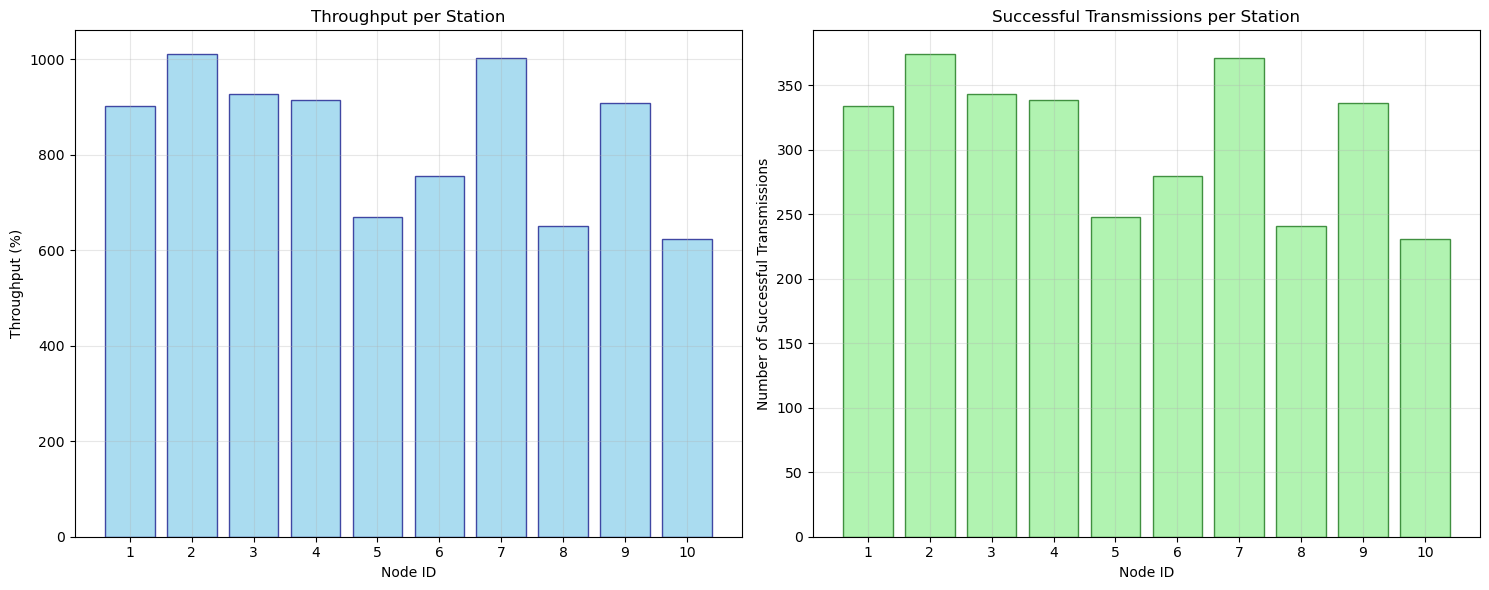

In [12]:
# Copy and paste this code into a new cell in your Jupyter notebook

# Calculate throughput for each station based on dflog
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters from your simulation
# beacon_interval = 100000  # microseconds
# frame_tx_slot = 300      # slots
# slot_time = 9            # microseconds per slot
# num_nodes = 10

# Calculate frame duration in microseconds
frame_duration = frame_tx_slot * slot_time  # microseconds

# Filter successful transmissions only
successful_tx = dflog[dflog['result'] == 'succ']

# Calculate throughput for each node
throughput_data = []
for node in range(1, num_nodes + 1):
    node_tx = successful_tx[successful_tx['node'] == node]
    num_successful_tx = len(node_tx)
    
    # Throughput = (Number of successful transmissions * Frame duration) / Total simulation time
    throughput = (num_successful_tx * frame_duration) / beacon_interval
    
    throughput_data.append({
        'node': node,
        'successful_tx': num_successful_tx,
        'throughput': throughput,
        'throughput_percentage': throughput * 100
    })

# Create DataFrame for throughput results
throughput_df = pd.DataFrame(throughput_data)

# Display results
print("Throughput Analysis for Each Station:")
print("=" * 50)
print(throughput_df.to_string(index=False))
print("\n" + "=" * 50)

# Calculate total system throughput
total_throughput = throughput_df['throughput'].sum()
total_successful_tx = throughput_df['successful_tx'].sum()

print(f"Total System Throughput: {total_throughput:.4f} ({total_throughput*100:.2f}%)")
print(f"Total Successful Transmissions: {total_successful_tx}")
print(f"Average Throughput per Node: {total_throughput/num_nodes:.4f} ({total_throughput*100/num_nodes:.2f}%)")

# Additional analysis: Show distribution of results
print("\nTransmission Result Distribution:")
result_counts = dflog['result'].value_counts()
print(result_counts)

# Calculate fairness index (Jain's fairness index)
throughputs = throughput_df['throughput'].to_numpy()
fairness_index = (np.sum(throughputs) ** 2) / (len(throughputs) * np.sum(throughputs ** 2))
print(f"\nFairness Index (Jain's): {fairness_index:.4f}")
print("Note: 1.0 = perfectly fair, lower values indicate unfairness")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of throughput per node
ax1.bar(throughput_df['node'], throughput_df['throughput_percentage'], 
        color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_xlabel('Node ID')
ax1.set_ylabel('Throughput (%)')
ax1.set_title('Throughput per Station')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, num_nodes + 1))

# Bar plot of successful transmissions per node
ax2.bar(throughput_df['node'], throughput_df['successful_tx'], 
        color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax2.set_xlabel('Node ID')
ax2.set_ylabel('Number of Successful Transmissions')
ax2.set_title('Successful Transmissions per Station')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, num_nodes + 1))

plt.tight_layout()
plt.show()
    